Single-qubit gate errors consisting of a single qubit depolarizing error followed by a single qubit thermal relaxation error.

Two-qubit gate errors consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.

Single-qubit readout errors on the classical bit value obtained from measurements on individual qubits.

For the gate errors the error parameter of the thermal relaxation errors is derived using the thermal_relaxation_error function from aer.noise.errors module, along with the individual qubit 
 and 
 parameters, and the gate_time parameter from the device backend properties. The probability of the depolarizing error is then set so that the combined average gate infidelity from the depolarizing error followed by the thermal relaxation is equal to the gate_error value from the backend properties.

For the readout errors the probability that the recorded classical bit value will be flipped from the true outcome after a measurement is given by the qubit readout_errors.

In [1]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ

import numpy as np


# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [2]:
from qiskit.providers.fake_provider import FakeVigo
device_backend = FakeVigo()
# will use ibm_brisbane as backend

properties = device_backend.properties()
temp = 0
noise_model= NoiseModel.from_backend_properties(
        backend_properties=properties,
        gate_error=True,
        readout_error=True,
        thermal_relaxation=True,
        temperature=0,
        gate_lengths=None,
        gate_length_units="ns",
        dt=None,
    )
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'id', 'sx', 'measure', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [3]:
# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

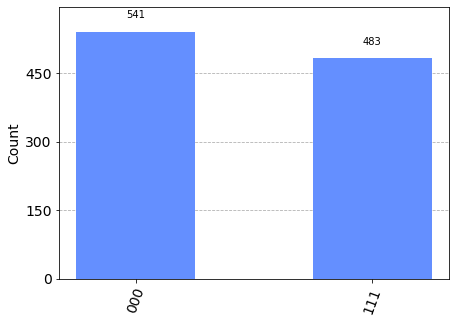

In [4]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

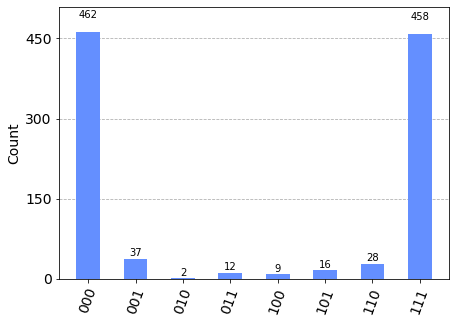

In [5]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

In [30]:
import qiskit
from mitiq import rem
from mitiq.rem import generate_tensored_inverse_confusion_matrix
from typing import Any, Sequence

def ibmq_noisy_executor(circuit, shots: int = 1024):
        """Returns the expectation value to be mitigated.
            Args:
            circuit: Circuit to run.
            shots: Number of times to execute the circuit to compute the expectation value.
        """
    
        # Simulate the circuit with noise
    
        job = qiskit.execute(
            experiments=circuit,
            backend=sim_noise,
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots,
        )

        # Convert from raw measurement counts to the expectation value
        counts = job.result().get_counts()
        if counts.get("0") is None:
            expectation_value = 0.
        else:
            expectation_value = counts.get("0") / shots
        return expectation_value

class AfterErrorMitigation:
    def __init__(self, circuit: QuantumCircuit):
        self.circuit = circuit
        self.qubits: list = circuit.qubits
        self.num_qubits = len(self.qubits)
        self.simulator = sim_noise
        
    
        
    def readout_mitigation_executor(self):
        A_list=[]
    
        for i in self.qubits:
            p1 = 0 # P(0|1)
            p0 = 0 # P(1|0)
            A_i = np.array([[1.0 - p0, p1],
                            [p0, 1.0 - p1]])
            A_list += [A_i]
        
        A_pinv = generate_tensored_inverse_confusion_matrix(self.num_qubits, A_list)
        rem_executor = rem.mitigate_executor(ibmq_noisy_executor, inverse_confusion_matrix=A_pinv)
        return rem_executor
    
    def ZNE_executor(self):
        pass
    def combine_executor(self):
        pass
    
    '''
    how to combine mutiple mitigation method, for example ZNE+REM:
    combined_executor = zne.mitigate_executor(circuit, rem_executor, scale_noise=zne.scaling.folding.fold_global)
    combined_result = combined_executor(circuit)
    '''
        
        
        
    def run(self):
        execute = self.readout_mitigation_executor()
        return execute(self.circuit).real
        

In [31]:
# can not run until finish combine_executor
AFE = AfterErrorMitigation(circ)
AFE.run()

TypeError: Result is not of type MeasurementResult.

In [13]:
A = np.array([[1.0, 0.],[0., 1.0]])
#A = np.kron(A, A)
A_pinv = generate_tensored_inverse_confusion_matrix(2, [A,A])